In [117]:
# Import statements
import pandas as pd, numpy as np, matplotlib.pyplot as plt, random, datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Read the preprocessed data
df = pd.read_csv('processed_data.csv')

In [3]:
# Round the latitude and longitude to 3 decimal places (about 100 meter radius) so they are less precise
df2 = df.round({'sg_c__latitude': 3, 'sg_c__longitude': 3})

In [8]:
df2

,date,date_range_start,sg_c__longitude,sg_c__latitude,sg_c__naics_code,season,visits
0,2019-01-07,2019-01-07,-79.948,32.728,531120.0,winter,32
1,2019-01-08,2019-01-07,-79.948,32.728,531120.0,winter,23
2,2019-01-09,2019-01-07,-79.948,32.728,531120.0,winter,27
3,2019-01-10,2019-01-07,-79.948,32.728,531120.0,winter,45
4,2019-01-11,2019-01-07,-79.948,32.728,531120.0,winter,40
...,...,...,...,...,...,...,...
10941975,2022-02-09,2022-02-07,-80.147,32.607,448140.0,winter,1
10941976,2022-02-10,2022-02-07,-80.147,32.607,448140.0,winter,0
10941977,2022-02-11,2022-02-07,-80.147,32.607,448140.0,winter,3
10941978,2022-02-12,2022-02-07,-80.147,32.607,448140.0,winter,1


In [5]:
df2.date = pd.to_datetime(df2.date)

In [6]:
df3 = df2.copy()

In [7]:
# Convert visits to rolling median to decrease the difference between weekends and weekdays
df3.visits = df3.visits.rolling(7).median()

In [42]:
df3 = df3.dropna().reset_index()

In [43]:
df3

,index,date,date_range_start,sg_c__longitude,sg_c__latitude,sg_c__naics_code,season,visits
0,6,2019-01-13,2019-01-07,-79.948,32.728,531120.0,winter,32.0
1,7,2019-01-07,2019-01-07,-79.949,32.790,722515.0,winter,27.0
2,8,2019-01-08,2019-01-07,-79.949,32.790,722515.0,winter,27.0
3,9,2019-01-09,2019-01-07,-79.949,32.790,722515.0,winter,25.0
4,10,2019-01-10,2019-01-07,-79.949,32.790,722515.0,winter,8.0
...,...,...,...,...,...,...,...,...
10941969,10941975,2022-02-09,2022-02-07,-80.147,32.607,448140.0,winter,2.0
10941970,10941976,2022-02-10,2022-02-07,-80.147,32.607,448140.0,winter,2.0
10941971,10941977,2022-02-11,2022-02-07,-80.147,32.607,448140.0,winter,2.0
10941972,10941978,2022-02-12,2022-02-07,-80.147,32.607,448140.0,winter,1.0


In [58]:
# Split into datasets for each season
winterS = df3[df3.season == 'winter']
springS = df3[df3.season == 'spring']
summerS = df3[df3.season == 'summer']
fallS = df3[df3.season == 'fall']

In [59]:
# Get the training data (Winter was difficult due to year differences so I left it out)
springTrain = springS[springS.date.dt.year != 2021]
summerTrain = summerS[summerS.date.dt.year != 2021]
fallTrain = fallS[fallS.date.dt.year != 2021]

springTest = springS[springS.date.dt.year == 2021]
summerTest = summerS[summerS.date.dt.year == 2021]
fallTest = fallS[fallS.date.dt.year == 2021]



In [62]:
# Subset data into relevant attributes and make date numerical
fallTrain = fallTrain[['date','sg_c__longitude', 'sg_c__latitude', 'visits']]
fallTest = fallTest[['date','sg_c__longitude', 'sg_c__latitude', 'visits']]
fallTrain.date = fallTrain.date.map(dt.datetime.toordinal)
fallTest.date = fallTest.date.map(dt.datetime.toordinal)

In [65]:
# Scale the data for K-Means - This one passed in fallTrain, but I also tested summer and 
# spring (performed equally poorly)
scaler = StandardScaler()
scaler.fit(fallTrain.drop('visits', axis = 1))
train_scaled_features = pd.DataFrame(scaler.transform(fallTrain.drop('visits', axis = 1)))
x_train = train_scaled_features
y_train = fallTrain.visits
    
# Fit the scaler to the x_test data
scaler.fit(fallTest.drop('visits', axis = 1))
# Scale the x_test data
test_scaled_features = pd.DataFrame(scaler.transform(fallTest.drop('visits', axis = 1)))
    
x_test = test_scaled_features
y_test = fallTest.visits

In [66]:
# Tested model for many different values of k
kmeans = KMeans(n_clusters=2).fit(x_train, y_train)

predictions = kmeans.predict(x_test)

In [68]:
# Output confusion matrix and classification report to see model performance
print(confusion_matrix(y_test.astype(str), predictions.astype(str)))
print(classification_report(y_test.astype(str), predictions.astype(str), zero_division = 0))



[[    0     0     0 ...     0     0     0]
 [96630     0 84680 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 ...
 [   63     0    83 ...     0     0     0]
 [   74     0    70 ...     0     0     0]
 [    0     0     1 ...     0     0     0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
         0.0       0.00      0.00      0.00  181310.0
           1       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00  170079.0
        10.0       0.00      0.00      0.00   17846.0
       100.0       0.00      0.00      0.00     153.0
      1005.0       0.00      0.00      0.00       1.0
      1006.0       0.00      0.00      0.00       5.0
       101.0       0.00      0.00      0.00     125.0
      1015.0       0.00      0.00      0.00       5.0
      1016.0       0.00      0.00      0.00       4.0
       102.0       0.00      0.00      0.00     119.0
      1029.0       0.00      0.00

### Visualization of Total Foot Traffic per Day for Charleston

In [81]:
# Calculate Total Foot Traffic per Day for the entire city
plot = df3[['date','visits']].groupby('date').agg(sum).reset_index()

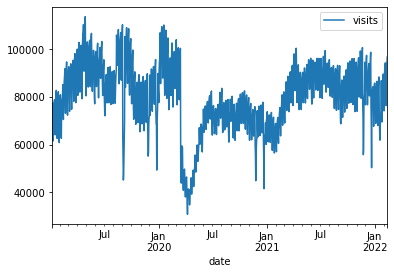

In [82]:
# Total Foot Traffic vs. Date
plot.plot('date', 'visits')

### Visual Comparison of Spring 2019 to Spring 2020 and Spring 2021

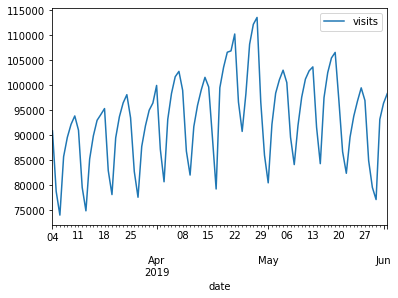

In [88]:
# Plot the Total Foot Traffic vs. Date for March 2019
springS[['date', 'visits']][springS.date.dt.year == 2019].groupby('date').agg(sum).reset_index().plot('date', 'visits')

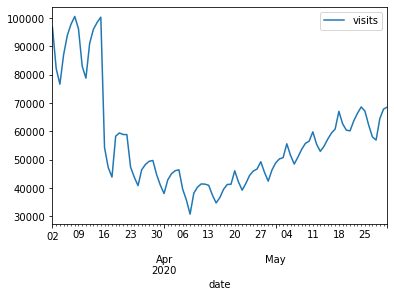

In [89]:
# Plot the Total Foot Traffic vs. Date for March 2020
springS[['date', 'visits']][springS.date.dt.year == 2020].groupby('date').agg(sum).reset_index().plot('date', 'visits')

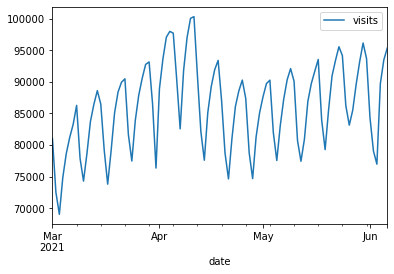

In [90]:
# Plot the Total Foot Traffic vs. Date for March 2021
springS[['date', 'visits']][springS.date.dt.year == 2021].groupby('date').agg(sum).reset_index().plot('date', 'visits')

### Visual Comparison of Summer 2019 to Summer 2020 and Summer 2021

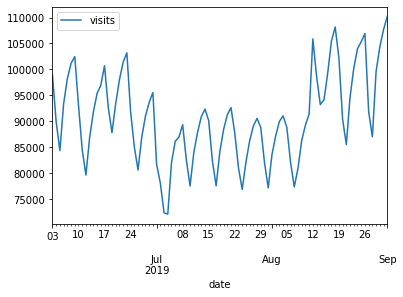

In [107]:
# Plot the Total Foot Traffic vs. Date for March 2019
summerS[['date', 'visits']][summerS.date.dt.year == 2019].groupby('date').agg(sum).reset_index().plot('date', 'visits')

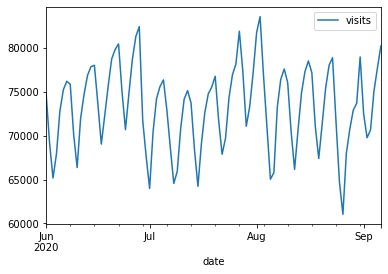

In [109]:
# Plot the Total Foot Traffic vs. Date for March 2020
summerS[['date', 'visits']][summerS.date.dt.year == 2020].groupby('date').agg(sum).reset_index().plot('date', 'visits')

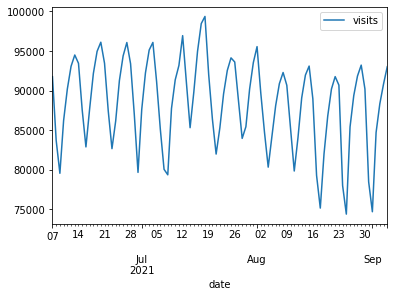

In [111]:
# Plot the Total Foot Traffic vs. Date for March 2021
summerS[['date', 'visits']][summerS.date.dt.year == 2021].groupby('date').agg(sum).reset_index().plot('date', 'visits')

### Visual Comparison of Fall 2019 to Fall 2020 and Fall 2021

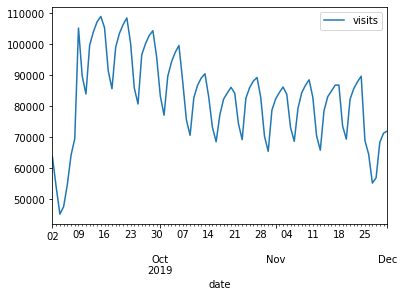

In [112]:
# Plot the Total Foot Traffic vs. Date for March 2019
fallS[['date', 'visits']][fallS.date.dt.year == 2019].groupby('date').agg(sum).reset_index().plot('date', 'visits')

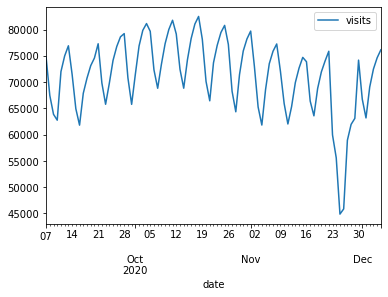

In [114]:
# Plot the Total Foot Traffic vs. Date for March 2020
fallS[['date', 'visits']][fallS.date.dt.year == 2020].groupby('date').agg(sum).reset_index().plot('date', 'visits')

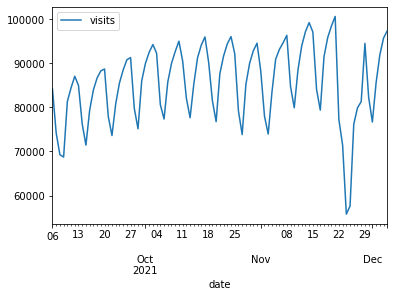

In [115]:
# Plot the Total Foot Traffic vs. Date for March 2021
fallS[['date', 'visits']][fallS.date.dt.year == 2021].groupby('date').agg(sum).reset_index().plot('date', 'visits')

### Visual Comparison of Winter 2019 to Winter 2020 and Winter 2021

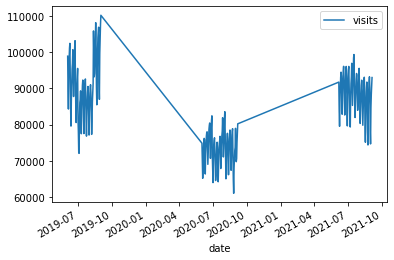

In [116]:
# Plot the Total Foot Traffic vs. Date for Winter Data
summerS[['date', 'visits']].groupby('date').agg(sum).reset_index().plot('date', 'visits')